In [1]:
import os
import cv2
import torch
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tqdm import tqdm
from scipy.stats import f_oneway
from deap import base, creator, tools
from multiprocessing.shared_memory import SharedMemory
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
def preload_images(image_paths):
    images = {}
    for path in image_paths:
        image = cv2.imread(path)
        if image is not None:
            images[path] = image
        else:
            print(f"Error loading image: {path}")
    return images

In [4]:
def process_single_image(image, rgb_range, area_range):
    try:
        r_min, r_max, g_min, g_max, b_min, b_max = rgb_range
        area_min, area_max = area_range

        mask = (
            (image[:, :, 2] >= r_min) & (image[:, :, 2] <= r_max) &  # R
            (image[:, :, 1] >= g_min) & (image[:, :, 1] <= g_max) &  # G
            (image[:, :, 0] >= b_min) & (image[:, :, 0] <= b_max)    # B
        )

        filtered_image = np.zeros_like(image[:, :, 0], dtype=np.uint8)
        filtered_image[mask] = 255

        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(filtered_image)

        areas = stats[1:, cv2.CC_STAT_AREA]
        filtered_areas = [area for area in areas if area_min <= area <= area_max]
        return filtered_areas
    except Exception as e:
        print(f"Error processing image: {e}")
        return []

In [5]:
def load_data_with_threadpool(images, rgb_range, area_range, max_workers=4):
    data = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_single_image, images[path], rgb_range, area_range)
            for path in images
        ]
        for future in as_completed(futures):
            try:
                # 각 이미지의 필터링된 영역 가져오기
                filtered_areas = future.result()
                if len(filtered_areas) > 0:  # 영역 개수가 0이 아닌 경우만 저장
                    data.append(len(filtered_areas))
            except Exception as e:
                print(f"Error in processing image: {e}")
    return data

In [6]:
def objective_function_f_stat(individual, soft_images, stiff_images):

    r_min, r_max, g_min, g_max, b_min, b_max, area_min, area_max = individual
    rgb_range = (r_min, r_max, g_min, g_max, b_min, b_max)
    area_range = (area_min, area_max)

    # 병렬 처리로 soft/stiff 영역 계산
    soft_areas = load_data_with_threadpool(soft_images, rgb_range, area_range, max_workers=4)
    stiff_areas = load_data_with_threadpool(stiff_images, rgb_range, area_range, max_workers=4)

    # 데이터 충분성 확인
    if len(soft_areas) < 50 or len(stiff_areas) < 50:
        print(f"Evaluating Individual: {individual} => F-stat: 0.0 (Insufficient data)")
        return 0.0,  # 최대 p-value (최적화되지 않은 상태)

    # F-통계량 계산
    try:
        f_stat, _ = f_oneway(soft_areas, stiff_areas)
        print(f"Evaluating Individual: {individual} => F-stat: {f_stat}")
        return f_stat, 
    except Exception as e:
        print(f"Error calculating F-stat for individual {individual}: {e}")
        return 0.0,

In [7]:
# 유효한 범위 생성 (min/max 자동 정렬)
def valid_range(low, high):
    a = random.randint(low, high)
    b = random.randint(low, high)
    return (min(a, b), max(a, b))

In [8]:
# 개체 생성 함수 정의
def create_individual():
    r_min, r_max = valid_range(0, 255)
    g_min, g_max = valid_range(0, 255)
    b_min, b_max = valid_range(0, 255)
    area_min, area_max = valid_range(1, 100)
    return creator.Individual([r_min, r_max, g_min, g_max, b_min, b_max, area_min, area_max])

In [9]:
def mate_ind(ind1, ind2):
    for i in range(0, len(ind1), 2):
        if random.random() < 0.5:
            ind1[i], ind2[i] = ind2[i], ind1[i]
            ind1[i + 1], ind2[i + 1] = ind2[i + 1], ind1[i + 1]
    return ind1, ind2

In [10]:
def mutate_fun(ind_list, mutate_type='rgb'):
    ind_min = ind_list[0]
    ind_max = ind_list[1]
    
    if mutate_type == 'rgb':
        max_up = 255
        num_var = 10
    elif mutate_type == 'area':
        max_up = 100
        num_var = 5
    else:
        print('Please input correct mutate_type: rgb, area')
        return [ind_min, ind_max]
    
    ind_range = (ind_max - ind_min)//2
    
    if ind_range >= ind_min:
        ind_min_low = 0
    else:
        ind_min_low = ind_min - ind_range
    ind_min_up = ind_min + ind_range

    if ind_range >= (max_up-ind_max):
        ind_max_up = max_up
    else:
        ind_max_up = ind_max + ind_range
    ind_max_low = ind_max - ind_range

    ind_min = random.randint(ind_min_low, ind_min_up)
    ind_max = random.randint(ind_max_low, ind_max_up)

    if (ind_max - ind_min) <= 3:
        if random.random() > 0.5:
            ind_min = ind_min - num_var
            if ind_min < 0:
                ind_min = 0
        if random.random() > 0.5:
            ind_max = ind_max + num_var
            if ind_max > max_up:
                ind_max = max_up

    return [ind_min, ind_max]

In [11]:
# 돌연변이 함수 (min/max 정렬 포함)
def mutate_ind(individual):
    if random.random() > 0.5:
        individual[0:2] = mutate_fun(individual[0:2], 'rgb')
        
    if random.random() > 0.5:
        individual[2:4] = mutate_fun(individual[2:4], 'rgb')
        
    if random.random() > 0.5:
        individual[4:6] = mutate_fun(individual[4:6], 'rgb')
        
    if random.random() > 0.5:
        individual[6:8] = mutate_fun(individual[6:8], 'area')

    return individual,

In [12]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", mate_ind)
toolbox.register("mutate", mutate_ind)
toolbox.register("select", tools.selTournament, tournsize=3)

In [13]:
def main_with_parallel():
    random.seed(42)

    # 이미지 경로 로드
    all_soft_paths = glob('./data/*/Soft/*_M.tif')
    all_stiff_paths = glob('./data/*/Stiff/*_M.tif')

    # 폴더 이름 9, 12 제외 필터링
    soft_image_paths = [p for p in all_soft_paths if not any(f"/{excluded}/" in p or f"\\{excluded}\\" in p for excluded in ['9', '12'])]
    stiff_image_paths = [p for p in all_stiff_paths if not any(f"/{excluded}/" in p or f"\\{excluded}\\" in p for excluded in ['9', '12'])]

    # 이미지 미리 로드
    print("Loading images into memory...")
    soft_images = preload_images(soft_image_paths)
    stiff_images = preload_images(stiff_image_paths)

    # 평가 함수에 데이터 전달
    toolbox.register("evaluate", objective_function_f_stat,
                     soft_images=soft_images, stiff_images=stiff_images)

    # 유전 알고리즘 실행
    population = toolbox.population(n=50)
    ngen = 50
    cxpb = 0.8
    mutpb = 0.5
    elite_size = 1

    print("Starting Genetic Algorithm with Parallel Processing...\n")
    
    for gen in tqdm(range(ngen), desc="Generations"):
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        elites = tools.selBest(population, k=elite_size)
        best_ind = tools.selBest(population, k=1)[0]
        f_stat = best_ind.fitness.values[0]
        print(f"\nGeneration {gen + 1}/{ngen}")
        print(f"Best Individual: {best_ind}")
        print(f"Best F-stat: {f_stat}")

        # 교배 및 돌연변이
        offspring = toolbox.select(population, len(population)-elite_size)
        offspring = list(map(toolbox.clone, offspring))
        
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
                
        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # 다음 세대 설정
        population[:] = elites + offspring

    best_individual = tools.selBest(population, k=1)[0]
    print("\nOptimization Complete!")
    print("Best Individual (RGB and Area Range):", best_individual)
    print("Best F-stat:", best_individual.fitness.values[0])

In [14]:
if __name__ == "__main__":
    main_with_parallel()

Loading images into memory...
Starting Genetic Algorithm with Parallel Processing...



Generations:   0%|                                                                              | 0/50 [00:00<?, ?it/s]

Evaluating Individual: [12, 57, 125, 140, 71, 114, 14, 95] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [44, 216, 15, 16, 47, 111, 30, 65] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [13, 101, 112, 214, 142, 229, 1, 98] => F-stat: 0.04425251544692334
Evaluating Individual: [81, 216, 142, 174, 79, 110, 44, 98] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [47, 52, 49, 194, 176, 183, 34, 78] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [22, 235, 63, 193, 40, 150, 80, 81] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [98, 185, 23, 35, 116, 148, 11, 30] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [51, 194, 142, 232, 83, 186, 46, 48] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [107, 136, 36, 87, 83, 125, 49, 60] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [112, 138, 28, 166, 16, 117, 41, 52] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [33, 137, 108, 161, 108, 255, 51, 83] 

Generations:   2%|█▍                                                                    | 1/50 [00:31<26:04, 31.92s/it]

Evaluating Individual: [19, 55, 176, 222, 160, 223, 66, 78] => F-stat: 0.0 (Insufficient data)

Generation 1/50
Best Individual: [4, 218, 38, 57, 18, 76, 48, 75]
Best F-stat: 9.737677822904931
Evaluating Individual: [4, 218, 38, 57, 18, 76, 48, 75] => F-stat: 9.737677822904928
Evaluating Individual: [51, 194, 78, 191, 0, 82, 42, 77] => F-stat: 9.048742109520662
Evaluating Individual: [110, 176, 142, 232, 83, 186, 41, 53] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [126, 171, 55, 81, 122, 134, 17, 51] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [127, 136, 104, 160, 19, 195, 29, 61] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [102, 235, 21, 60, 165, 200, 4, 85] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [24, 178, 160, 185, 105, 116, 2, 44] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [39, 148, 30, 128, 64, 154, 22, 53] => F-stat: 2.3632792883264617
Evaluating Individual: [50, 226, 7, 25, 30, 36, 9, 30] => F-stat: 0.0 (

Generations:   4%|██▊                                                                   | 2/50 [01:04<25:40, 32.08s/it]

Evaluating Individual: [9, 250, 57, 185, 122, 157, 8, 31] => F-stat: 0.25542400842278307

Generation 2/50
Best Individual: [4, 218, 38, 57, 18, 76, 48, 75]
Best F-stat: 9.737677822904928
Evaluating Individual: [4, 218, 38, 57, 18, 76, 48, 75] => F-stat: 9.737677822904928
Evaluating Individual: [4, 218, 38, 57, 18, 76, 48, 75] => F-stat: 9.737677822904933
Evaluating Individual: [235, 255, 109, 205, 19, 47, 23, 68] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [75, 220, 21, 65, 102, 159, 11, 30] => F-stat: 0.13472677222976903
Evaluating Individual: [98, 185, 5, 58, 116, 148, 52, 86] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [80, 222, 80, 119, 41, 132, 1, 46] => F-stat: 0.6030771226672359
Evaluating Individual: [99, 149, 70, 170, 84, 134, 38, 45] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [54, 238, 63, 193, 40, 150, 63, 76] => F-stat: 2.4359834474965094
Evaluating Individual: [140, 199, 73, 113, 79, 208, 6, 36] => F-stat: 0.03615051274301244
Eval

Generations:   6%|████▏                                                                 | 3/50 [01:36<25:09, 32.12s/it]

Evaluating Individual: [10, 201, 63, 193, 40, 168, 63, 76] => F-stat: 0.9489433985614739

Generation 3/50
Best Individual: [24, 178, 78, 191, 0, 82, 2, 44]
Best F-stat: 12.329038847032091
Evaluating Individual: [24, 178, 78, 191, 0, 82, 2, 44] => F-stat: 12.329038847032091
Evaluating Individual: [140, 199, 63, 193, 40, 150, 6, 36] => F-stat: 0.02125814730045537
Evaluating Individual: [20, 148, 89, 131, 123, 158, 60, 74] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [4, 218, 43, 50, 18, 76, 54, 79] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [61, 234, 51, 126, 91, 134, 15, 60] => F-stat: 3.003027370594104
Evaluating Individual: [143, 197, 51, 126, 64, 196, 35, 41] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [135, 250, 47, 109, 92, 117, 17, 51] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [80, 222, 51, 126, 18, 76, 17, 51] => F-stat: 1.3460840622204915
Evaluating Individual: [4, 218, 109, 205, 91, 134, 22, 53] => F-stat: 0.0 (Insuffici

Generations:   8%|█████▌                                                                | 4/50 [02:08<24:43, 32.24s/it]

Evaluating Individual: [29, 185, 26, 128, 91, 134, 26, 51] => F-stat: 2.6537921848538004

Generation 4/50
Best Individual: [24, 178, 78, 191, 0, 82, 2, 44]
Best F-stat: 12.329038847032091
Evaluating Individual: [24, 178, 78, 191, 0, 82, 2, 44] => F-stat: 12.32903884703209
Evaluating Individual: [54, 238, 63, 193, 91, 124, 63, 76] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [4, 151, 26, 128, 4, 202, 26, 51] => F-stat: 5.429705646371336
Evaluating Individual: [74, 152, 51, 126, 76, 134, 15, 60] => F-stat: 5.471401292481886
Evaluating Individual: [29, 185, 26, 128, 91, 124, 26, 51] => F-stat: 4.450842876535873
Evaluating Individual: [10, 201, 63, 193, 91, 134, 14, 65] => F-stat: 3.0854865134938736
Evaluating Individual: [153, 223, 86, 157, 18, 203, 69, 77] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [29, 185, 26, 128, 91, 134, 18, 67] => F-stat: 2.494460162098175
Evaluating Individual: [66, 169, 115, 189, 0, 82, 14, 65] => F-stat: 0.20025017982787918
Evaluating

Generations:  10%|███████                                                               | 5/50 [02:41<24:14, 32.31s/it]

Evaluating Individual: [29, 185, 26, 128, 91, 124, 26, 51] => F-stat: 4.450842876535873

Generation 5/50
Best Individual: [24, 178, 78, 191, 0, 82, 2, 44]
Best F-stat: 12.32903884703209
Evaluating Individual: [24, 178, 78, 191, 0, 82, 2, 44] => F-stat: 12.329038847032091
Evaluating Individual: [54, 238, 63, 193, 91, 134, 26, 51] => F-stat: 4.164715742617407
Evaluating Individual: [126, 222, 117, 155, 77, 115, 26, 79] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [97, 248, 112, 213, 91, 134, 38, 48] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [51, 207, 63, 193, 40, 132, 31, 76] => F-stat: 0.32731674444379943
Evaluating Individual: [15, 253, 60, 125, 91, 134, 11, 30] => F-stat: 1.8823496020631527
Evaluating Individual: [4, 151, 46, 91, 25, 254, 19, 60] => F-stat: 1.2266020254274645
Evaluating Individual: [80, 222, 51, 126, 38, 70, 63, 76] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [53, 205, 17, 232, 17, 163, 17, 51] => F-stat: 1.7131061560308165
E

Generations:  12%|████████▍                                                             | 6/50 [03:13<23:45, 32.39s/it]

Evaluating Individual: [96, 157, 1, 194, 91, 134, 14, 65] => F-stat: 7.1112298111996886

Generation 6/50
Best Individual: [24, 178, 78, 191, 0, 82, 2, 44]
Best F-stat: 12.329038847032093
Evaluating Individual: [24, 178, 78, 191, 0, 82, 2, 44] => F-stat: 12.329038847032091
Evaluating Individual: [80, 222, 51, 126, 91, 134, 14, 65] => F-stat: 2.4236002243541503
Evaluating Individual: [10, 201, 63, 193, 7, 112, 18, 48] => F-stat: 4.85488710323696
Evaluating Individual: [0, 138, 23, 166, 75, 117, 2, 44] => F-stat: 0.5264946130236264
Evaluating Individual: [21, 147, 48, 154, 0, 82, 29, 61] => F-stat: 10.015308217168997
Evaluating Individual: [18, 221, 113, 229, 14, 82, 18, 48] => F-stat: 1.142991961362666
Evaluating Individual: [24, 178, 51, 126, 7, 112, 2, 44] => F-stat: 15.251100940621223
Evaluating Individual: [115, 170, 1, 194, 72, 120, 20, 91] => F-stat: 2.2594858979568224
Evaluating Individual: [96, 157, 63, 193, 91, 134, 14, 65] => F-stat: 9.940123737219773
Evaluating Individual: [50

Generations:  14%|█████████▊                                                            | 7/50 [03:46<23:17, 32.50s/it]

Evaluating Individual: [24, 178, 78, 191, 0, 82, 2, 44] => F-stat: 12.32903884703209

Generation 7/50
Best Individual: [24, 178, 51, 126, 7, 112, 2, 44]
Best F-stat: 15.251100940621223
Evaluating Individual: [24, 178, 51, 126, 7, 112, 2, 44] => F-stat: 15.251100940621223
Evaluating Individual: [74, 152, 51, 126, 0, 82, 15, 60] => F-stat: 3.530521546439033
Evaluating Individual: [75, 150, 36, 188, 91, 134, 19, 51] => F-stat: 11.807351607406
Evaluating Individual: [10, 201, 63, 193, 7, 112, 18, 48] => F-stat: 4.85488710323696
Evaluating Individual: [82, 163, 44, 230, 17, 163, 30, 36] => F-stat: 1.1081164290072132
Evaluating Individual: [24, 178, 65, 93, 91, 134, 22, 38] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [80, 222, 78, 191, 0, 82, 14, 65] => F-stat: 6.528806542579298
Evaluating Individual: [21, 147, 63, 193, 0, 82, 14, 65] => F-stat: 10.598690947853703
Evaluating Individual: [120, 171, 133, 164, 91, 134, 41, 65] => F-stat: 0.0 (Insufficient data)
Evaluating Individu

Generations:  16%|███████████▏                                                          | 8/50 [04:20<23:00, 32.88s/it]

Evaluating Individual: [82, 163, 63, 193, 91, 134, 26, 51] => F-stat: 5.843368235339584

Generation 8/50
Best Individual: [24, 178, 51, 126, 7, 112, 2, 44]
Best F-stat: 15.251100940621223
Evaluating Individual: [24, 178, 51, 126, 7, 112, 2, 44] => F-stat: 15.251100940621223
Evaluating Individual: [95, 205, 51, 126, 12, 56, 12, 36] => F-stat: 2.8190554390796465
Evaluating Individual: [91, 187, 78, 191, 7, 112, 21, 60] => F-stat: 0.4027200003511425
Evaluating Individual: [117, 217, 86, 152, 0, 108, 40, 75] => F-stat: 0.010323259599190483
Evaluating Individual: [65, 200, 78, 191, 0, 82, 29, 61] => F-stat: 6.973239398440022
Evaluating Individual: [44, 123, 48, 154, 0, 82, 23, 49] => F-stat: 6.755113186302431
Evaluating Individual: [7, 115, 78, 191, 0, 82, 2, 44] => F-stat: 7.527759618992861
Evaluating Individual: [65, 200, 48, 154, 86, 118, 19, 54] => F-stat: 5.307179743256722
Evaluating Individual: [26, 205, 125, 170, 24, 94, 15, 57] => F-stat: 0.04060217729240348
Evaluating Individual: [

Generations:  18%|████████████▌                                                         | 9/50 [04:54<22:41, 33.20s/it]

Evaluating Individual: [53, 205, 63, 193, 103, 127, 9, 75] => F-stat: 7.361824697548033

Generation 9/50
Best Individual: [24, 178, 51, 126, 7, 112, 2, 44]
Best F-stat: 15.251100940621223
Evaluating Individual: [24, 178, 51, 126, 7, 112, 2, 44] => F-stat: 15.251100940621223
Evaluating Individual: [64, 208, 99, 147, 0, 82, 19, 25] => F-stat: 1.189280904888927
Evaluating Individual: [80, 222, 51, 126, 7, 112, 2, 44] => F-stat: 7.760911331195395
Evaluating Individual: [24, 178, 51, 126, 8, 112, 32, 59] => F-stat: 5.936174202279276
Evaluating Individual: [24, 178, 51, 126, 7, 112, 2, 44] => F-stat: 15.251100940621223
Evaluating Individual: [82, 153, 121, 221, 33, 94, 23, 49] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [29, 224, 48, 145, 36, 53, 2, 44] => F-stat: 1.5785344318362073
Evaluating Individual: [10, 103, 62, 102, 7, 112, 24, 65] => F-stat: 0.54306111822993
Evaluating Individual: [25, 219, 61, 158, 12, 159, 6, 41] => F-stat: 8.103372167687525
Evaluating Individual: [6

Generations:  20%|█████████████▊                                                       | 10/50 [05:28<22:19, 33.50s/it]

Evaluating Individual: [24, 178, 45, 205, 0, 82, 38, 69] => F-stat: 8.640529031720853

Generation 10/50
Best Individual: [24, 178, 51, 126, 3, 61, 13, 49]
Best F-stat: 15.519092084202011
Evaluating Individual: [24, 178, 51, 126, 3, 61, 13, 49] => F-stat: 15.519092084202011
Evaluating Individual: [24, 178, 78, 191, 7, 112, 2, 44] => F-stat: 11.114750198837479
Evaluating Individual: [58, 203, 51, 126, 7, 112, 2, 44] => F-stat: 11.706437155178467
Evaluating Individual: [27, 209, 62, 223, 0, 82, 2, 44] => F-stat: 12.750238468273155
Evaluating Individual: [80, 123, 32, 96, 7, 112, 12, 60] => F-stat: 0.0980621714746864
Evaluating Individual: [24, 178, 63, 193, 0, 82, 2, 44] => F-stat: 13.515586877648515
Evaluating Individual: [32, 219, 28, 201, 12, 159, 14, 39] => F-stat: 3.696215071870549
Evaluating Individual: [7, 115, 78, 191, 3, 61, 2, 44] => F-stat: 8.351042905647374
Evaluating Individual: [24, 178, 80, 115, 0, 82, 19, 51] => F-stat: 4.961233747782958
Evaluating Individual: [31, 163, 51

Generations:  22%|███████████████▏                                                     | 11/50 [06:02<21:51, 33.63s/it]

Evaluating Individual: [23, 207, 36, 188, 16, 96, 13, 49] => F-stat: 0.9974360079326515

Generation 11/50
Best Individual: [24, 178, 51, 126, 3, 61, 13, 49]
Best F-stat: 15.519092084202011
Evaluating Individual: [24, 178, 51, 126, 3, 61, 13, 49] => F-stat: 15.519092084202011
Evaluating Individual: [24, 178, 78, 191, 32, 148, 7, 65] => F-stat: 1.6170454385729471
Evaluating Individual: [24, 178, 63, 193, 0, 82, 17, 40] => F-stat: 11.038294590564186
Evaluating Individual: [24, 178, 80, 115, 0, 82, 19, 51] => F-stat: 4.961233747782958
Evaluating Individual: [56, 243, 110, 243, 27, 92, 42, 77] => F-stat: 0.6260558688356097
Evaluating Individual: [21, 147, 78, 191, 0, 82, 18, 48] => F-stat: 7.938117358790742
Evaluating Individual: [24, 178, 78, 191, 0, 82, 38, 69] => F-stat: 11.842654510929908
Evaluating Individual: [73, 253, 104, 247, 2, 107, 38, 69] => F-stat: 4.128364866060124
Evaluating Individual: [147, 177, 116, 140, 33, 121, 6, 41] => F-stat: 0.0 (Insufficient data)
Evaluating Individ

Generations:  24%|████████████████▌                                                    | 12/50 [06:36<21:24, 33.80s/it]

Evaluating Individual: [41, 232, 63, 193, 0, 82, 1, 21] => F-stat: 11.275949667098391

Generation 12/50
Best Individual: [27, 209, 62, 223, 3, 61, 13, 49]
Best F-stat: 16.5834044328331
Evaluating Individual: [27, 209, 62, 223, 3, 61, 13, 49] => F-stat: 16.5834044328331
Evaluating Individual: [45, 146, 7, 173, 3, 61, 20, 55] => F-stat: 1.1328534272524868
Evaluating Individual: [27, 209, 62, 223, 3, 61, 13, 49] => F-stat: 16.583404432833092
Evaluating Individual: [75, 150, 51, 126, 7, 112, 2, 44] => F-stat: 7.463743754167093
Evaluating Individual: [24, 178, 63, 193, 0, 82, 2, 44] => F-stat: 13.515586877648511
Evaluating Individual: [31, 163, 51, 126, 8, 77, 2, 44] => F-stat: 11.173857938705215
Evaluating Individual: [21, 147, 78, 191, 0, 113, 1, 21] => F-stat: 12.424342777523494
Evaluating Individual: [93, 130, 51, 126, 26, 99, 45, 73] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [24, 178, 78, 191, 7, 112, 2, 44] => F-stat: 11.114750198837484
Evaluating Individual: [60, 217,

Generations:  26%|█████████████████▉                                                   | 13/50 [07:10<20:58, 34.01s/it]

Evaluating Individual: [98, 226, 63, 193, 0, 82, 2, 57] => F-stat: 6.614513535876614

Generation 13/50
Best Individual: [24, 178, 51, 126, 3, 61, 38, 69]
Best F-stat: 21.571284681514367
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [27, 209, 62, 223, 3, 61, 13, 49] => F-stat: 16.583404432833092
Evaluating Individual: [159, 189, 118, 199, 0, 82, 2, 57] => F-stat: 0.3527017207082146
Evaluating Individual: [32, 130, 78, 191, 0, 82, 13, 49] => F-stat: 6.812689043187963
Evaluating Individual: [24, 178, 62, 223, 9, 90, 0, 51] => F-stat: 12.365315075682206
Evaluating Individual: [24, 178, 63, 193, 0, 82, 2, 44] => F-stat: 13.515586877648511
Evaluating Individual: [24, 178, 8, 236, 30, 83, 6, 59] => F-stat: 1.5085445984520107
Evaluating Individual: [32, 130, 66, 116, 3, 61, 1, 49] => F-stat: 11.20594223558074
Evaluating Individual: [31, 163, 62, 223, 8, 77, 2, 44] => F-stat: 10.512595281102824
Evaluating Individual: [24, 178, 63, 1

Generations:  28%|███████████████████▎                                                 | 14/50 [07:45<20:31, 34.21s/it]

Evaluating Individual: [49, 199, 63, 134, 3, 87, 15, 66] => F-stat: 8.236393827790797

Generation 14/50
Best Individual: [24, 178, 51, 126, 3, 61, 38, 69]
Best F-stat: 21.57128468151437
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [52, 129, 54, 104, 0, 82, 38, 78] => F-stat: 2.7182502899005043
Evaluating Individual: [24, 178, 21, 211, 3, 61, 2, 44] => F-stat: 0.5445548834976137
Evaluating Individual: [87, 214, 51, 126, 3, 61, 13, 35] => F-stat: 7.11207511491274
Evaluating Individual: [24, 178, 62, 223, 0, 82, 3, 53] => F-stat: 12.982428366788236
Evaluating Individual: [31, 163, 51, 126, 7, 112, 2, 44] => F-stat: 14.835075621889857
Evaluating Individual: [67, 189, 51, 126, 3, 61, 25, 61] => F-stat: 6.3047526075385045
Evaluating Individual: [24, 178, 62, 223, 3, 61, 3, 53] => F-stat: 14.411780473223871
Evaluating Individual: [24, 178, 26, 229, 0, 82, 2, 30] => F-stat: 3.2042838858976985
Evaluating Individual: [24, 178, 27, 1

Generations:  30%|████████████████████▋                                                | 15/50 [08:20<20:01, 34.33s/it]

Evaluating Individual: [31, 163, 63, 193, 3, 61, 2, 44] => F-stat: 13.389473850000336

Generation 15/50
Best Individual: [24, 178, 51, 126, 3, 61, 38, 69]
Best F-stat: 21.57128468151437
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [31, 163, 51, 126, 9, 90, 13, 32] => F-stat: 4.5283528594698375
Evaluating Individual: [24, 178, 77, 124, 59, 115, 2, 44] => F-stat: 0.7187772137528282
Evaluating Individual: [24, 178, 62, 223, 0, 82, 13, 49] => F-stat: 10.078094076547325
Evaluating Individual: [24, 178, 51, 126, 3, 61, 3, 53] => F-stat: 12.540335252001638
Evaluating Individual: [24, 178, 51, 126, 3, 61, 2, 44] => F-stat: 11.943365741750156
Evaluating Individual: [31, 163, 80, 237, 48, 79, 21, 68] => F-stat: 0.3575775218515479
Evaluating Individual: [24, 178, 57, 151, 3, 61, 3, 53] => F-stat: 13.20062476608671
Evaluating Individual: [24, 178, 62, 223, 6, 69, 2, 44] => F-stat: 13.911489768139432
Evaluating Individual: [27, 209, 62

Generations:  32%|██████████████████████                                               | 16/50 [08:54<19:28, 34.37s/it]

Evaluating Individual: [22, 150, 11, 153, 3, 61, 23, 58] => F-stat: 0.0034142406756905836

Generation 16/50
Best Individual: [24, 178, 51, 126, 3, 61, 38, 69]
Best F-stat: 21.57128468151437
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [27, 209, 62, 223, 3, 61, 13, 49] => F-stat: 16.5834044328331
Evaluating Individual: [27, 209, 62, 223, 3, 61, 13, 49] => F-stat: 16.5834044328331
Evaluating Individual: [24, 178, 62, 223, 3, 61, 3, 53] => F-stat: 14.411780473223871
Evaluating Individual: [24, 178, 62, 223, 3, 61, 3, 53] => F-stat: 14.411780473223871
Evaluating Individual: [91, 233, 12, 169, 3, 61, 10, 58] => F-stat: 1.337582589316149
Evaluating Individual: [19, 154, 62, 223, 22, 49, 18, 57] => F-stat: 5.992312243220415
Evaluating Individual: [70, 178, 54, 133, 3, 61, 38, 69] => F-stat: 5.435725838338966
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.571284681514374
Evaluating Individual: [48, 208, 63,

Generations:  34%|███████████████████████▍                                             | 17/50 [09:29<18:56, 34.43s/it]

Evaluating Individual: [24, 178, 51, 126, 3, 61, 3, 53] => F-stat: 12.540335252001647

Generation 17/50
Best Individual: [24, 178, 51, 126, 3, 61, 38, 69]
Best F-stat: 21.571284681514374
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [3, 205, 126, 189, 2, 88, 3, 48] => F-stat: 1.88113529530084
Evaluating Individual: [27, 209, 62, 223, 3, 61, 26, 53] => F-stat: 19.394523677805694
Evaluating Individual: [3, 205, 62, 223, 3, 61, 26, 53] => F-stat: 20.57475505383672
Evaluating Individual: [27, 209, 62, 223, 1, 79, 13, 49] => F-stat: 11.932300586966115
Evaluating Individual: [24, 178, 51, 126, 7, 112, 13, 49] => F-stat: 8.921120146420336
Evaluating Individual: [24, 178, 62, 223, 7, 112, 2, 44] => F-stat: 17.01881754147596
Evaluating Individual: [24, 178, 62, 223, 3, 61, 38, 69] => F-stat: 15.103743357072187
Evaluating Individual: [27, 209, 62, 223, 1, 62, 13, 49] => F-stat: 18.122855977199727
Evaluating Individual: [42, 165, 51, 

Generations:  36%|████████████████████████▊                                            | 18/50 [10:03<18:21, 34.42s/it]

Evaluating Individual: [27, 209, 71, 139, 3, 61, 31, 61] => F-stat: 9.489053403191432

Generation 18/50
Best Individual: [24, 178, 51, 126, 3, 61, 38, 69]
Best F-stat: 21.57128468151437
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.571284681514367
Evaluating Individual: [48, 129, 62, 223, 3, 61, 38, 69] => F-stat: 3.8750053976404444
Evaluating Individual: [24, 178, 51, 126, 3, 61, 3, 53] => F-stat: 12.540335252001647
Evaluating Individual: [27, 209, 79, 143, 3, 61, 26, 53] => F-stat: 7.305161702205859
Evaluating Individual: [31, 204, 62, 223, 3, 61, 10, 54] => F-stat: 16.47572330032362
Evaluating Individual: [27, 209, 118, 146, 3, 61, 29, 55] => F-stat: 1.468994873437004
Evaluating Individual: [24, 178, 62, 223, 3, 61, 38, 69] => F-stat: 15.103743357072187
Evaluating Individual: [31, 163, 51, 126, 3, 61, 13, 49] => F-stat: 14.18910342093706
Evaluating Individual: [59, 242, 62, 223, 1, 62, 45, 84] => F-stat: 9.40668673698516
Evaluating Individual: [24, 178, 64, 

Generations:  38%|██████████████████████████▏                                          | 19/50 [10:38<17:47, 34.45s/it]

Evaluating Individual: [93, 188, 62, 223, 25, 79, 2, 44] => F-stat: 1.539973878373687

Generation 19/50
Best Individual: [24, 178, 51, 126, 3, 61, 38, 69]
Best F-stat: 21.571284681514378
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [115, 216, 30, 218, 3, 61, 13, 49] => F-stat: 3.906897564421832
Evaluating Individual: [27, 209, 62, 223, 3, 61, 13, 49] => F-stat: 16.5834044328331
Evaluating Individual: [5, 227, 125, 154, 21, 87, 26, 53] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [23, 163, 64, 188, 3, 61, 26, 53] => F-stat: 14.97100789905693
Evaluating Individual: [27, 209, 64, 188, 3, 61, 13, 49] => F-stat: 17.643634702449738
Evaluating Individual: [27, 209, 97, 220, 27, 83, 38, 69] => F-stat: 0.7187660453768256
Evaluating Individual: [27, 209, 51, 126, 3, 61, 12, 38] => F-stat: 14.52392094597023
Evaluating Individual: [24, 178, 64, 188, 3, 61, 38, 69] => F-stat: 13.343176692574525
Evaluating Individual: [27, 

Generations:  40%|███████████████████████████▌                                         | 20/50 [11:12<17:14, 34.49s/it]

Evaluating Individual: [23, 163, 62, 223, 3, 61, 26, 53] => F-stat: 17.41448666616076

Generation 20/50
Best Individual: [24, 178, 51, 126, 3, 61, 38, 69]
Best F-stat: 21.571284681514378
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.571284681514367
Evaluating Individual: [23, 163, 51, 126, 3, 61, 26, 53] => F-stat: 16.03423916454313
Evaluating Individual: [24, 178, 45, 242, 7, 50, 38, 69] => F-stat: 18.001366810551144
Evaluating Individual: [7, 125, 86, 139, 3, 61, 26, 70] => F-stat: 1.6612045343758386
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [27, 209, 64, 188, 3, 61, 13, 49] => F-stat: 17.643634702449724
Evaluating Individual: [59, 254, 51, 126, 3, 61, 3, 53] => F-stat: 7.733670173720846
Evaluating Individual: [27, 209, 76, 96, 3, 61, 10, 34] => F-stat: 4.780187725898056
Evaluating Individual: [24, 178, 37, 140, 3, 61, 5, 69] => F-stat: 5.216684614524921
Evaluating Individual: [27, 209, 39, 19

Generations:  42%|████████████████████████████▉                                        | 21/50 [11:47<16:39, 34.47s/it]

Evaluating Individual: [23, 163, 62, 223, 3, 61, 26, 53] => F-stat: 17.41448666616076

Generation 21/50
Best Individual: [28, 221, 51, 126, 3, 61, 38, 69]
Best F-stat: 23.049603295234178
Evaluating Individual: [28, 221, 51, 126, 3, 61, 38, 69] => F-stat: 23.049603295234178
Evaluating Individual: [31, 204, 18, 111, 0, 57, 44, 84] => F-stat: 0.08870660736771568
Evaluating Individual: [24, 178, 64, 188, 3, 61, 13, 49] => F-stat: 16.351752340387332
Evaluating Individual: [27, 209, 62, 223, 3, 61, 26, 53] => F-stat: 19.394523677805694
Evaluating Individual: [27, 209, 51, 126, 3, 61, 13, 49] => F-stat: 15.641803723359397
Evaluating Individual: [24, 178, 62, 223, 3, 61, 13, 49] => F-stat: 15.728397382219862
Evaluating Individual: [27, 209, 51, 126, 3, 61, 10, 54] => F-stat: 15.104728557281206
Evaluating Individual: [24, 178, 62, 223, 3, 61, 13, 49] => F-stat: 15.72839738221986
Evaluating Individual: [27, 209, 68, 174, 8, 79, 13, 49] => F-stat: 6.66809744970816
Evaluating Individual: [27, 209,

Generations:  44%|██████████████████████████████▎                                      | 22/50 [12:21<16:04, 34.44s/it]

Evaluating Individual: [10, 81, 38, 113, 6, 36, 42, 64] => F-stat: 9.416218007091707

Generation 22/50
Best Individual: [28, 221, 51, 126, 3, 61, 38, 69]
Best F-stat: 23.049603295234185
Evaluating Individual: [28, 221, 51, 126, 3, 61, 38, 69] => F-stat: 23.04960329523417
Evaluating Individual: [24, 178, 85, 180, 2, 39, 36, 60] => F-stat: 2.984471413590414
Evaluating Individual: [27, 209, 62, 223, 3, 61, 13, 49] => F-stat: 16.5834044328331
Evaluating Individual: [27, 209, 62, 223, 3, 61, 26, 53] => F-stat: 19.394523677805694
Evaluating Individual: [32, 132, 51, 126, 3, 61, 26, 53] => F-stat: 13.727449703175775
Evaluating Individual: [24, 178, 45, 242, 3, 61, 0, 53] => F-stat: 9.580838017102138
Evaluating Individual: [14, 156, 51, 126, 3, 61, 26, 53] => F-stat: 16.037118825787243
Evaluating Individual: [28, 221, 73, 203, 3, 61, 38, 69] => F-stat: 11.608919045046878
Evaluating Individual: [27, 191, 51, 126, 29, 62, 33, 49] => F-stat: 8.705218986244278
Evaluating Individual: [55, 227, 34, 

Generations:  46%|███████████████████████████████▋                                     | 23/50 [12:55<15:29, 34.44s/it]

Evaluating Individual: [27, 209, 62, 223, 32, 86, 13, 49] => F-stat: 1.178563330703432

Generation 23/50
Best Individual: [28, 221, 51, 126, 3, 61, 38, 69]
Best F-stat: 23.049603295234178
Evaluating Individual: [28, 221, 51, 126, 3, 61, 38, 69] => F-stat: 23.049603295234178
Evaluating Individual: [28, 221, 78, 160, 3, 61, 10, 54] => F-stat: 14.980714384748113
Evaluating Individual: [25, 234, 24, 126, 3, 61, 38, 69] => F-stat: 0.3559855974840578
Evaluating Individual: [81, 183, 51, 126, 6, 89, 26, 53] => F-stat: 1.9104085763507046
Evaluating Individual: [24, 178, 55, 163, 3, 61, 21, 44] => F-stat: 16.514858211285617
Evaluating Individual: [24, 178, 51, 126, 3, 61, 37, 71] => F-stat: 22.31132564869151
Evaluating Individual: [55, 125, 51, 126, 3, 61, 38, 69] => F-stat: 3.5923328077790906
Evaluating Individual: [28, 221, 51, 126, 3, 61, 38, 69] => F-stat: 23.049603295234178
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [14, 156

Generations:  48%|█████████████████████████████████                                    | 24/50 [13:30<14:56, 34.47s/it]

Evaluating Individual: [28, 221, 51, 126, 3, 61, 38, 69] => F-stat: 23.049603295234178

Generation 24/50
Best Individual: [13, 236, 51, 126, 3, 61, 38, 69]
Best F-stat: 24.962052270827435
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.96205227082743
Evaluating Individual: [78, 185, 97, 168, 3, 61, 38, 69] => F-stat: 0.2090259401186285
Evaluating Individual: [27, 209, 51, 126, 3, 61, 31, 49] => F-stat: 19.637221616145904
Evaluating Individual: [55, 210, 14, 246, 3, 61, 38, 69] => F-stat: 0.765427427766203
Evaluating Individual: [24, 178, 51, 126, 3, 61, 13, 49] => F-stat: 15.519092084202011
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.96205227082743
Evaluating Individual: [28, 221, 51, 126, 3, 61, 38, 69] => F-stat: 23.04960329523417
Evaluating Individual: [38, 221, 51, 126, 3, 61, 38, 69] => F-stat: 20.499472525307553
Evaluating Individual: [72, 233, 51, 126, 29, 79, 15, 39] => F-stat: 2.157400612438963
Evaluating Individual: [27, 209, 

Generations:  50%|██████████████████████████████████▌                                  | 25/50 [14:04<14:20, 34.43s/it]

Evaluating Individual: [14, 156, 51, 126, 3, 61, 26, 53] => F-stat: 16.037118825787246

Generation 25/50
Best Individual: [13, 236, 51, 126, 3, 61, 38, 69]
Best F-stat: 24.96205227082743
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.96205227082743
Evaluating Individual: [31, 128, 66, 135, 3, 61, 6, 86] => F-stat: 9.607287500778586
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.962052270827428
Evaluating Individual: [24, 178, 62, 223, 3, 61, 38, 69] => F-stat: 15.103743357072187
Evaluating Individual: [24, 178, 55, 163, 25, 40, 21, 42] => F-stat: 7.006153553551859
Evaluating Individual: [90, 231, 51, 126, 9, 38, 48, 66] => F-stat: 0.345169294670921
Evaluating Individual: [39, 207, 51, 126, 19, 49, 38, 69] => F-stat: 3.9467589976489657
Evaluating Individual: [73, 221, 51, 126, 3, 61, 21, 44] => F-stat: 6.772370006919299
Evaluating Individual: [24, 178, 62, 223, 32, 47, 38, 69] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [13, 

Generations:  52%|███████████████████████████████████▉                                 | 26/50 [14:39<13:48, 34.52s/it]

Evaluating Individual: [87, 131, 69, 133, 3, 61, 50, 68] => F-stat: 0.0 (Insufficient data)

Generation 26/50
Best Individual: [13, 236, 51, 126, 3, 61, 38, 69]
Best F-stat: 24.962052270827442
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.962052270827435
Evaluating Individual: [27, 209, 51, 126, 3, 61, 13, 49] => F-stat: 15.641803723359404
Evaluating Individual: [28, 221, 51, 126, 3, 61, 38, 69] => F-stat: 23.049603295234178
Evaluating Individual: [96, 160, 51, 126, 3, 61, 5, 72] => F-stat: 6.474233394267793
Evaluating Individual: [20, 156, 51, 126, 3, 61, 38, 69] => F-stat: 18.66695077434557
Evaluating Individual: [24, 178, 51, 126, 3, 61, 29, 82] => F-stat: 18.127884348448028
Evaluating Individual: [13, 236, 51, 126, 27, 37, 27, 75] => F-stat: 2.090661516911913
Evaluating Individual: [27, 209, 64, 188, 5, 90, 38, 69] => F-stat: 5.323279532093393
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.962052270827435
Evaluating Individual: [13, 

Generations:  54%|█████████████████████████████████████▎                               | 27/50 [15:14<13:14, 34.56s/it]

Evaluating Individual: [27, 209, 51, 126, 3, 61, 44, 58] => F-stat: 21.273878704964943

Generation 27/50
Best Individual: [28, 221, 51, 126, 2, 48, 36, 59]
Best F-stat: 25.997751941024017
Evaluating Individual: [28, 221, 51, 126, 2, 48, 36, 59] => F-stat: 25.997751941024017
Evaluating Individual: [33, 211, 80, 140, 3, 61, 34, 74] => F-stat: 4.8469508254809694
Evaluating Individual: [40, 234, 51, 126, 31, 73, 38, 69] => F-stat: 4.1774211117230085
Evaluating Individual: [28, 221, 51, 126, 3, 61, 38, 69] => F-stat: 23.049603295234178
Evaluating Individual: [1, 117, 51, 126, 3, 61, 38, 69] => F-stat: 16.58912905335901
Evaluating Individual: [101, 148, 59, 152, 3, 61, 47, 59] => F-stat: 1.118137140206416
Evaluating Individual: [28, 221, 51, 126, 3, 61, 38, 69] => F-stat: 23.049603295234178
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.571284681514367
Evaluating Individual: [13, 236, 65, 101, 32, 36, 38, 69] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [

Generations:  56%|██████████████████████████████████████▋                              | 28/50 [15:48<12:39, 34.51s/it]

Evaluating Individual: [10, 127, 53, 106, 3, 61, 38, 69] => F-stat: 9.819585634765533

Generation 28/50
Best Individual: [28, 221, 51, 126, 2, 48, 40, 62]
Best F-stat: 26.805440365684266
Evaluating Individual: [28, 221, 51, 126, 2, 48, 40, 62] => F-stat: 26.805440365684266
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [24, 178, 51, 126, 3, 61, 38, 69] => F-stat: 21.57128468151437
Evaluating Individual: [59, 231, 82, 145, 3, 61, 49, 51] => F-stat: 1.3675264941498688
Evaluating Individual: [28, 221, 51, 126, 2, 48, 38, 69] => F-stat: 23.406241916248742
Evaluating Individual: [46, 125, 51, 126, 12, 40, 38, 69] => F-stat: 0.8423374058316747
Evaluating Individual: [28, 139, 65, 125, 6, 47, 38, 69] => F-stat: 4.191656272878966
Evaluating Individual: [21, 149, 80, 155, 17, 80, 33, 67] => F-stat: 2.257293540759809
Evaluating Individual: [27, 209, 18, 138, 12, 43, 38, 69] => F-stat: 0.3687650030215702
Evaluating Individual: [13, 236

Generations:  58%|████████████████████████████████████████                             | 29/50 [16:23<12:06, 34.57s/it]

Evaluating Individual: [13, 236, 49, 159, 3, 61, 44, 66] => F-stat: 24.6327386697636

Generation 29/50
Best Individual: [28, 221, 51, 126, 2, 48, 40, 62]
Best F-stat: 26.805440365684266
Evaluating Individual: [28, 221, 51, 126, 2, 48, 40, 62] => F-stat: 26.805440365684266
Evaluating Individual: [77, 194, 53, 106, 32, 58, 47, 70] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [10, 127, 51, 126, 3, 61, 38, 69] => F-stat: 16.610218192859275
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.96205227082743
Evaluating Individual: [24, 178, 59, 104, 4, 71, 38, 69] => F-stat: 4.267396735267943
Evaluating Individual: [28, 221, 51, 126, 24, 36, 23, 74] => F-stat: 2.2615872775297468
Evaluating Individual: [13, 236, 51, 126, 3, 61, 40, 62] => F-stat: 24.238693971346343
Evaluating Individual: [28, 221, 57, 123, 1, 49, 38, 69] => F-stat: 16.49028978783656
Evaluating Individual: [24, 178, 49, 159, 24, 83, 37, 54] => F-stat: 2.0939499648266784
Evaluating Individual: [13

Generations:  60%|█████████████████████████████████████████▍                           | 30/50 [16:57<11:31, 34.56s/it]

Evaluating Individual: [5, 239, 49, 159, 4, 72, 38, 69] => F-stat: 14.051057499389763

Generation 30/50
Best Individual: [28, 221, 51, 126, 2, 48, 40, 62]
Best F-stat: 26.805440365684266
Evaluating Individual: [28, 221, 51, 126, 2, 48, 40, 62] => F-stat: 26.805440365684266
Evaluating Individual: [13, 236, 66, 109, 30, 76, 49, 58] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [24, 178, 49, 159, 3, 61, 38, 69] => F-stat: 21.84058121431627
Evaluating Individual: [27, 209, 19, 127, 3, 61, 38, 69] => F-stat: 0.0584073978603107
Evaluating Individual: [13, 236, 60, 145, 11, 60, 38, 84] => F-stat: 6.6411916758691865
Evaluating Individual: [13, 236, 49, 159, 3, 61, 38, 69] => F-stat: 23.271584852446416
Evaluating Individual: [24, 178, 51, 126, 3, 61, 44, 66] => F-stat: 20.33958882549184
Evaluating Individual: [13, 236, 57, 123, 1, 49, 38, 69] => F-stat: 18.663146401561292
Evaluating Individual: [28, 221, 51, 126, 3, 61, 40, 62] => F-stat: 22.778464725837868
Evaluating Individual: [7

Generations:  62%|██████████████████████████████████████████▊                          | 31/50 [17:32<10:55, 34.52s/it]

Evaluating Individual: [55, 142, 51, 126, 3, 61, 38, 69] => F-stat: 4.951986488297903

Generation 31/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [75, 231, 55, 98, 28, 33, 38, 69] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [13, 236, 49, 159, 3, 61, 38, 69] => F-stat: 23.271584852446427
Evaluating Individual: [13, 236, 49, 159, 3, 61, 44, 66] => F-stat: 24.632738669763597
Evaluating Individual: [13, 236, 49, 159, 3, 61, 38, 69] => F-stat: 23.271584852446416
Evaluating Individual: [13, 236, 21, 145, 3, 61, 29, 60] => F-stat: 0.5298058147720567
Evaluating Individual: [13, 236, 21, 145, 3, 61, 38, 69] => F-stat: 0.9048946650797122
Evaluating Individual: [5, 239, 51, 126, 3, 61, 38, 69] => F-stat: 25.355841214999693
Evaluating Individual: [27, 202, 51, 126, 3, 61, 41, 82] => F-stat: 21.61328685129708
Evaluating Individual: [24,

Generations:  64%|████████████████████████████████████████████▏                        | 32/50 [18:06<10:20, 34.44s/it]

Evaluating Individual: [27, 209, 30, 169, 3, 61, 40, 74] => F-stat: 2.1066718515924965

Generation 32/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [27, 209, 51, 126, 3, 61, 38, 69] => F-stat: 24.167061760815496
Evaluating Individual: [101, 188, 51, 126, 3, 61, 40, 62] => F-stat: 2.4352238545039873
Evaluating Individual: [5, 239, 51, 126, 2, 48, 30, 70] => F-stat: 29.12728617640096
Evaluating Individual: [101, 255, 82, 200, 15, 70, 38, 78] => F-stat: 0.29636657346938267
Evaluating Individual: [53, 138, 32, 94, 3, 61, 38, 69] => F-stat: 7.013018282567579
Evaluating Individual: [117, 209, 51, 126, 20, 90, 38, 69] => F-stat: 1.1399063051811724
Evaluating Individual: [27, 209, 49, 159, 2, 48, 30, 70] => F-stat: 27.844102213033864
Evaluating Individual: [13, 236, 54, 154, 3, 61, 38, 69] => F-stat: 23.409860275353644
Evaluating Individual: [88,

Generations:  66%|█████████████████████████████████████████████▌                       | 33/50 [18:41<09:47, 34.54s/it]

Evaluating Individual: [5, 239, 51, 126, 3, 61, 38, 69] => F-stat: 25.355841214999693

Generation 33/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637
Evaluating Individual: [11, 216, 51, 126, 3, 61, 38, 69] => F-stat: 25.01980387640224
Evaluating Individual: [13, 236, 49, 159, 3, 44, 51, 58] => F-stat: 11.734486170233385
Evaluating Individual: [117, 178, 49, 159, 3, 44, 31, 77] => F-stat: 3.921634596301833
Evaluating Individual: [13, 236, 49, 159, 21, 55, 38, 69] => F-stat: 9.769228175787843
Evaluating Individual: [80, 138, 49, 159, 3, 61, 32, 60] => F-stat: 4.709875302389353
Evaluating Individual: [13, 236, 51, 126, 8, 83, 38, 69] => F-stat: 9.235679614493405
Evaluating Individual: [47, 245, 47, 162, 21, 72, 45, 55] => F-stat: 2.227711119052722
Evaluating Individual: [5, 239, 51, 126, 2, 48, 38, 69] => F-stat: 27.217823918346575
Evaluating Individual: [5, 239, 51,

Generations:  68%|██████████████████████████████████████████████▉                      | 34/50 [19:15<09:11, 34.48s/it]

Evaluating Individual: [5, 239, 51, 126, 3, 61, 38, 69] => F-stat: 25.355841214999685

Generation 34/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 52, 195, 2, 48, 38, 69] => F-stat: 31.294576279512675
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 61] => F-stat: 31.860946495551826
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.96205227082745
Evaluating Individual: [5, 239, 49, 159, 2, 48, 30, 70] => F-stat: 31.36575583702029
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.962052270827435
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.962052270827435
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.962052270827435
Evaluating Individual: [5, 239, 51, 126, 3, 61, 28, 72] => F-stat: 21.86159320309519
Evaluating Individual: [29, 137, 51,

Generations:  70%|████████████████████████████████████████████████▎                    | 35/50 [19:50<08:40, 34.69s/it]

Evaluating Individual: [5, 239, 51, 126, 2, 48, 30, 70] => F-stat: 29.127286176400972

Generation 35/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637
Evaluating Individual: [5, 239, 51, 126, 3, 61, 28, 72] => F-stat: 21.861593203095186
Evaluating Individual: [13, 236, 76, 189, 15, 43, 30, 61] => F-stat: 2.676830619399597
Evaluating Individual: [27, 209, 51, 126, 3, 61, 38, 69] => F-stat: 24.167061760815496
Evaluating Individual: [5, 239, 64, 183, 10, 49, 30, 70] => F-stat: 13.524642239654066
Evaluating Individual: [13, 236, 52, 195, 2, 48, 38, 69] => F-stat: 31.294576279512675
Evaluating Individual: [5, 239, 51, 126, 15, 56, 28, 72] => F-stat: 7.577478959577699
Evaluating Individual: [13, 236, 67, 123, 3, 61, 30, 67] => F-stat: 10.053847837986778
Evaluating Individual: [13, 236, 49, 159, 2, 48, 26, 55] => F-stat: 28.86920834834769
Evaluating Individual: [13, 236, 4

Generations:  72%|█████████████████████████████████████████████████▋                   | 36/50 [20:25<08:04, 34.61s/it]

Evaluating Individual: [5, 239, 49, 159, 3, 61, 38, 69] => F-stat: 23.47024308973578

Generation 36/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 2, 48, 19, 86] => F-stat: 27.46936060093399
Evaluating Individual: [49, 174, 51, 133, 2, 48, 30, 70] => F-stat: 11.938448034903125
Evaluating Individual: [108, 159, 49, 159, 17, 68, 30, 61] => F-stat: 0.12104064930570249
Evaluating Individual: [13, 236, 49, 159, 3, 61, 38, 69] => F-stat: 23.271584852446423
Evaluating Individual: [73, 218, 49, 159, 6, 25, 37, 56] => F-stat: 6.148160536053896
Evaluating Individual: [13, 236, 49, 159, 2, 48, 38, 69] => F-stat: 30.036517103663424
Evaluating Individual: [13, 236, 51, 126, 3, 61, 38, 69] => F-stat: 24.96205227082743
Evaluating Individual: [13, 236, 73, 147, 7, 48, 60, 79] => F-stat: 3.3093492735612826
Evaluating Individual: [13, 236,

Generations:  74%|███████████████████████████████████████████████████                  | 37/50 [20:59<07:29, 34.57s/it]

Evaluating Individual: [5, 239, 51, 126, 3, 61, 38, 69] => F-stat: 25.355841214999693

Generation 37/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [5, 239, 51, 126, 3, 61, 42, 64] => F-stat: 24.162792328786296
Evaluating Individual: [37, 200, 51, 126, 2, 48, 38, 69] => F-stat: 18.261582297544695
Evaluating Individual: [5, 239, 51, 126, 3, 61, 38, 69] => F-stat: 25.355841214999693
Evaluating Individual: [5, 239, 51, 126, 3, 61, 38, 69] => F-stat: 25.355841214999693
Evaluating Individual: [5, 239, 49, 159, 17, 47, 38, 69] => F-stat: 7.556216665669361
Evaluating Individual: [13, 236, 49, 159, 3, 61, 19, 86] => F-stat: 18.209390256933165
Evaluating Individual: [49, 174, 51, 133, 2, 48, 30, 70] => F-stat: 11.938448034903121
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 52,

Generations:  76%|████████████████████████████████████████████████████▍                | 38/50 [21:34<06:54, 34.52s/it]

Evaluating Individual: [18, 182, 41, 187, 3, 61, 48, 72] => F-stat: 12.606280508392928

Generation 38/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 52, 195, 3, 61, 28, 64] => F-stat: 20.92818918516669
Evaluating Individual: [13, 236, 51, 126, 2, 48, 38, 69] => F-stat: 26.816776277844948
Evaluating Individual: [27, 209, 25, 134, 2, 48, 31, 79] => F-stat: 1.2767449632320524
Evaluating Individual: [2, 230, 49, 159, 2, 48, 38, 69] => F-stat: 28.656482681558504
Evaluating Individual: [5, 239, 49, 159, 3, 61, 38, 69] => F-stat: 23.470243089735778
Evaluating Individual: [13, 236, 49, 159, 2, 48, 38, 69] => F-stat: 30.036517103663428
Evaluating Individual: [15, 241, 105, 125, 2, 48, 36, 51] => F-stat: 0.012606406845685505
Evaluating Individual: [5, 239, 65, 152, 28, 55, 42, 64] => F-stat: 3.479985703863625
Evaluating Individual: [15, 241

Generations:  78%|█████████████████████████████████████████████████████▊               | 39/50 [22:08<06:18, 34.43s/it]

Evaluating Individual: [97, 204, 51, 126, 3, 61, 47, 74] => F-stat: 3.039805681350715

Generation 39/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [5, 239, 51, 126, 2, 48, 38, 69] => F-stat: 27.217823918346575
Evaluating Individual: [5, 239, 51, 126, 2, 48, 38, 69] => F-stat: 27.217823918346575
Evaluating Individual: [2, 230, 96, 173, 17, 59, 10, 75] => F-stat: 4.466206343806126
Evaluating Individual: [12, 194, 49, 159, 2, 48, 26, 79] => F-stat: 28.364483847244138
Evaluating Individual: [13, 236, 52, 195, 3, 61, 30, 70] => F-stat: 22.40110137128032
Evaluating Individual: [13, 236, 79, 187, 18, 50, 45, 74] => F-stat: 4.071323579345906
Evaluating Individual: [72, 201, 11, 145, 2, 48, 38, 69] => F-stat: 1.3242049660940423
Evaluating Individual: [14, 156, 92, 170, 2, 48, 38, 65] => F-stat: 1.9657048286947316
Evaluating Individual: [113, 136, 4

Generations:  80%|███████████████████████████████████████████████████████▏             | 40/50 [22:42<05:44, 34.43s/it]

Evaluating Individual: [13, 236, 51, 126, 27, 54, 31, 62] => F-stat: 5.907284810587965

Generation 40/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786375
Evaluating Individual: [97, 216, 49, 159, 16, 61, 20, 74] => F-stat: 1.1059586321236337
Evaluating Individual: [70, 126, 73, 151, 2, 54, 29, 70] => F-stat: 2.120323842766074
Evaluating Individual: [5, 239, 51, 126, 3, 61, 38, 69] => F-stat: 25.355841214999693
Evaluating Individual: [5, 239, 51, 126, 3, 61, 38, 69] => F-stat: 25.355841214999693
Evaluating Individual: [22, 216, 49, 159, 0, 42, 41, 68] => F-stat: 24.683638860702793
Evaluating Individual: [13, 236, 49, 159, 25, 66, 31, 56] => F-stat: 5.491984621322773
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236

Generations:  82%|████████████████████████████████████████████████████████▌            | 41/50 [23:17<05:11, 34.62s/it]

Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637

Generation 41/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786375
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637
Evaluating Individual: [5, 239, 49, 159, 3, 61, 38, 69] => F-stat: 23.470243089735778
Evaluating Individual: [13, 236, 52, 195, 2, 48, 38, 69] => F-stat: 31.294576279512675
Evaluating Individual: [42, 241, 51, 126, 18, 60, 40, 68] => F-stat: 4.510319695389119
Evaluating Individual: [23, 144, 49, 159, 27, 51, 30, 70] => F-stat: 3.425821995629502
Evaluating Individual: [30, 229, 112, 169, 22, 34, 38, 69] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [5, 239, 51, 126, 1, 76, 23, 83] => F-stat: 15.64825752374579
Evaluating Individual: [13, 236, 52, 195, 2, 48, 45, 50] => F-stat: 8.534282902694756
Evaluating Individual: [13, 236, 12, 186, 23, 67, 29, 70] => F-stat: 0.10514539397246402
Evaluating Individual: [10

Generations:  84%|█████████████████████████████████████████████████████████▉           | 42/50 [23:52<04:36, 34.53s/it]

Evaluating Individual: [13, 236, 49, 159, 2, 48, 26, 56] => F-stat: 29.03267502690848

Generation 42/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [24, 155, 49, 159, 14, 68, 17, 63] => F-stat: 1.699686132108551
Evaluating Individual: [22, 216, 49, 159, 2, 48, 30, 70] => F-stat: 29.188617110202586
Evaluating Individual: [78, 197, 80, 182, 2, 48, 13, 66] => F-stat: 6.133924508942445
Evaluating Individual: [5, 239, 49, 159, 1, 47, 48, 64] => F-stat: 25.4921211511292
Evaluating Individual: [116, 130, 49, 159, 0, 42, 22, 98] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [22, 125, 37, 162, 31, 70, 41, 68] => F-stat: 0.8796590844975526
Evaluating Individual: [13, 236, 49, 159, 2, 48, 38, 69] => F-stat: 30.036517103663428
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637
Evaluating Individual: [84, 1

Generations:  86%|███████████████████████████████████████████████████████████▎         | 43/50 [24:26<04:01, 34.53s/it]

Evaluating Individual: [63, 149, 49, 159, 4, 44, 38, 69] => F-stat: 3.92478798228552

Generation 43/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786375
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 50, 128, 2, 48, 30, 70] => F-stat: 27.169129204038658
Evaluating Individual: [13, 236, 49, 159, 2, 48, 38, 69] => F-stat: 30.036517103663424
Evaluating Individual: [13, 236, 103, 114, 19, 38, 26, 73] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786375
Evaluating Individual: [50, 224, 49, 159, 2, 48, 45, 73] => F-stat: 10.33319995554519
Evaluating Individual: [13, 236, 24, 210, 2, 48, 46, 58] => F-stat: 0.48004223968951787
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 22, 62, 30, 70] => F-stat: 7.3903835962440985
Evaluating Individual: [

Generations:  88%|████████████████████████████████████████████████████████████▋        | 44/50 [25:00<03:26, 34.47s/it]

Evaluating Individual: [28, 163, 49, 159, 19, 64, 30, 70] => F-stat: 3.0230133479721455

Generation 44/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786375
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 6, 31, 38, 69] => F-stat: 11.80890133195316
Evaluating Individual: [49, 252, 49, 159, 2, 48, 30, 70] => F-stat: 15.077989912174901
Evaluating Individual: [13, 236, 49, 159, 7, 60, 52, 65] => F-stat: 11.4047161636007
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 21, 188, 24, 64, 30, 70] => F-stat: 0.02104383053442215
Evaluating Individual: [55, 166, 96, 159, 7, 36, 23, 82] => F-stat: 0.5494083094692958
Evaluating Individual: [13, 236, 49, 159, 3, 61, 38, 69] => F-stat: 23.271584852446416
Evaluating Individual: [122, 177, 52, 195, 2, 48, 15, 82] => F-stat: 3.1826736535505207
Evaluating Individual: [13, 

Generations:  90%|██████████████████████████████████████████████████████████████       | 45/50 [25:35<02:52, 34.48s/it]

Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365

Generation 45/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786375
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [70, 212, 49, 159, 17, 39, 31, 60] => F-stat: 1.2896354956993321
Evaluating Individual: [13, 236, 84, 170, 25, 48, 30, 70] => F-stat: 0.5939448020199828
Evaluating Individual: [13, 236, 49, 159, 9, 29, 38, 69] => F-stat: 7.135735700066915
Evaluating Individual: [131, 250, 79, 201, 21, 64, 48, 85] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [47, 250, 49, 159, 11, 58, 30, 70] => F-stat: 5.03989983738173
Evaluating Individual: [13, 236, 49, 159, 3, 61, 38, 69] => F-stat: 23.271584852446423
Evaluating Individual: [22, 158, 49, 159, 14, 71, 50, 54] => F-stat: 2.625899584182617
Evaluating Individual: [13, 236, 49, 159, 2, 48, 38, 69] => F-stat: 30.036517103663424
Evaluating Individual:

Generations:  92%|███████████████████████████████████████████████████████████████▍     | 46/50 [26:09<02:17, 34.45s/it]

Evaluating Individual: [42, 201, 54, 200, 11, 62, 17, 52] => F-stat: 5.891316612191159

Generation 46/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [58, 190, 49, 159, 2, 48, 19, 64] => F-stat: 10.070097453907257
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [115, 158, 49, 159, 2, 48, 10, 59] => F-stat: 5.247050171435599
Evaluating Individual: [13, 236, 96, 114, 2, 48, 11, 87] => F-stat: 1.0715079366388072
Evaluating Individual: [57, 246, 48, 182, 2, 48, 26, 85] => F-stat: 12.526638038129517
Evaluating Individual: [13, 236, 49, 159, 2, 48, 38, 69] => F-stat: 30.036517103663424
Evaluating Individual: [13, 236, 49, 159, 2, 48, 48, 69] => F-stat: 24.378146227912385
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [17, 19

Generations:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [26:44<01:43, 34.47s/it]

Evaluating Individual: [121, 216, 17, 174, 3, 60, 38, 69] => F-stat: 1.7301707681131457

Generation 47/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786375
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [70, 137, 49, 159, 1, 17, 30, 70] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 23, 31, 39, 85] => F-stat: 0.0 (Insufficient data)
Evaluating Individual: [13, 224, 19, 201, 11, 68, 7, 79] => F-stat: 0.9705948935893891
Evaluating Individual: [36, 244, 42, 150, 20, 32, 30, 70] => F-stat: 3.210605104707466
Evaluating Individual: [13, 236, 49, 159, 3, 30, 30, 70] => F-stat: 18.975002208339298
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [111, 238, 0, 164, 2, 48, 30, 70] => F-stat: 1.1187003301890521
Evaluating Indivi

Generations:  96%|██████████████████████████████████████████████████████████████████▏  | 48/50 [27:18<01:08, 34.46s/it]

Evaluating Individual: [13, 236, 49, 159, 22, 54, 35, 55] => F-stat: 8.98760901301914

Generation 48/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786375
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [5, 239, 49, 159, 17, 66, 21, 68] => F-stat: 3.7087869157011992
Evaluating Individual: [13, 236, 71, 214, 3, 61, 30, 70] => F-stat: 15.079779522640482
Evaluating Individual: [13, 236, 49, 159, 3, 30, 30, 70] => F-stat: 18.975002208339298
Evaluating Individual: [75, 220, 49, 159, 16, 59, 30, 70] => F-stat: 1.1547215418108947
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 2, 48, 20, 52] => F-stat: 26.46402142965384
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236

Generations:  98%|███████████████████████████████████████████████████████████████████▌ | 49/50 [27:53<00:34, 34.49s/it]

Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637

Generation 49/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786375
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.91875254278637
Evaluating Individual: [13, 236, 21, 132, 2, 48, 30, 70] => F-stat: 0.13892894229924757
Evaluating Individual: [13, 236, 73, 136, 2, 48, 10, 60] => F-stat: 14.630130564163624
Evaluating Individual: [13, 236, 95, 132, 2, 48, 36, 85] => F-stat: 0.8104568196075759
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365
Evaluating Individual: [13, 236, 49, 159, 2, 48, 14, 50] => F-stat: 23.02747600243641
Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786375
Evaluating Individual: [13, 236, 43, 184, 15, 42, 30, 70] => F-stat: 8.796207806148056
Evaluating Individual: [13, 236, 49, 159, 0, 27, 24, 80] => F-stat: 19.537347974704623
Evaluating Individual: [13, 236

Generations: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [28:27<00:00, 34.15s/it]

Evaluating Individual: [13, 236, 49, 159, 2, 48, 30, 70] => F-stat: 31.918752542786365

Generation 50/50
Best Individual: [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786375

Optimization Complete!
Best Individual (RGB and Area Range): [13, 236, 49, 159, 2, 48, 30, 70]
Best F-stat: 31.918752542786375


In [12]:
# 이미지 경로 로드
all_soft_paths = glob('./data/*/Soft/*_M.tif')
all_stiff_paths = glob('./data/*/Stiff/*_M.tif')

# 폴더 이름 9, 12 제외 필터링
soft_image_paths = [p for p in all_soft_paths if not any(f"/{excluded}/" in p or f"\\{excluded}\\" in p for excluded in ['9', '12'])]
stiff_image_paths = [p for p in all_stiff_paths if not any(f"/{excluded}/" in p or f"\\{excluded}\\" in p for excluded in ['9', '12'])]

# 이미지 미리 로드
print("Loading images into memory...")
soft_images = preload_images(soft_image_paths)
stiff_images = preload_images(stiff_image_paths)

Loading images into memory...


In [13]:
print(len(soft_images))
print(len(stiff_images))

85
100


In [14]:
r_min, r_max, g_min, g_max, b_min, b_max, area_min, area_max = [13, 236, 49, 159, 2, 48, 30, 70]
rgb_range = (r_min, r_max, g_min, g_max, b_min, b_max)
area_range = (area_min, area_max)

soft_areas = load_data_with_threadpool(soft_images, rgb_range, area_range, max_workers=4)
stiff_areas = load_data_with_threadpool(stiff_images, rgb_range, area_range, max_workers=4)

In [15]:
# 1. t-test
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(stiff_areas, soft_areas, equal_var=False)

# 2. Effect size (Cohen's d)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_sd

effect_size = cohens_d(stiff_areas, soft_areas)

In [21]:
t_stat

np.float64(5.77660519900098)

C:\Users\cczzt\AppData\Local\Temp\ipykernel_21108\1050223249.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


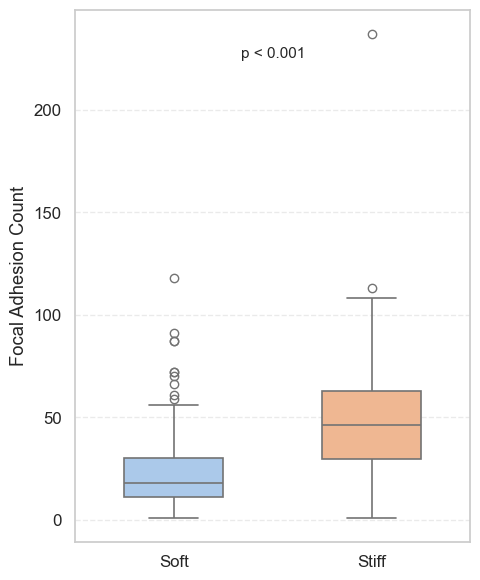

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터프레임 생성
df = pd.DataFrame({
    'Condition': ['Soft'] * len(soft_areas) + ['Stiff'] * len(stiff_areas),
    'Adhesion Count': soft_areas + stiff_areas
})

# 스타일 설정 (논문용)
plt.figure(figsize=(5, 6))
sns.set(style='whitegrid', font_scale=1.1)

# Boxplot 그리기
ax = sns.boxplot(
    x='Condition',
    y='Adhesion Count',
    data=df,
    palette='pastel',
    width=0.5,
    linewidth=1.2
)

# 제목/라벨/스타일 설정
plt.ylabel('Focal Adhesion Count')
plt.xlabel('')
plt.grid(True, axis='y', linestyle='--', alpha=0.4)

# p-value 텍스트 (옵션)
plt.text(0.5, max(stiff_areas) * 0.95, "p < 0.001", ha='center', fontsize=11)

# 저장
plt.tight_layout()
plt.savefig("../cell/figure/fig4.png", dpi=300, bbox_inches='tight')

# 출력
plt.show()

In [17]:
df.to_csv('./figure/vector/(Fig4) Boxplot.csv', index=False)

In [18]:
import pandas as pd
print('##### Soft FA #####')
print(pd.Series(soft_areas).describe())
print()
print('##### Stiff FA #####')
print(pd.Series(stiff_areas).describe())

##### Soft FA #####
count     85.000000
mean      26.435294
std       23.110216
min        1.000000
25%       11.000000
50%       18.000000
75%       30.000000
max      118.000000
dtype: float64

##### Stiff FA #####
count    100.000000
mean      49.270000
std       30.565662
min        1.000000
25%       29.750000
50%       46.000000
75%       63.000000
max      237.000000
dtype: float64


In [36]:
import matplotlib.pyplot as plt

def process_and_visualize_labels(image, rgb_range, area_range):
    try:
        r_min, r_max, g_min, g_max, b_min, b_max = rgb_range
        area_min, area_max = area_range

        mask = (
            (image[:, :, 2] >= r_min) & (image[:, :, 2] <= r_max) &  # R
            (image[:, :, 1] >= g_min) & (image[:, :, 1] <= g_max) &  # G
            (image[:, :, 0] >= b_min) & (image[:, :, 0] <= b_max)    # B
        )

        filtered_image = np.zeros_like(image)
        filtered_image[mask] = image[mask]

        filtered_gray = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(filtered_gray)

        labeled_image = image.copy()
        filtered_labeled_image = filtered_image.copy()

        areas = stats[1:, cv2.CC_STAT_AREA]
        valid_labels = [i + 1 for i, area in enumerate(areas) if area_min <= area <= area_max]

        for label in valid_labels:
            component_mask = (labels == label).astype(np.uint8) * 255
            contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(labeled_image, contours, -1, (255, 0, 0), 2)
            cv2.drawContours(filtered_labeled_image, contours, -1, (255, 0, 0), 2)

        return labeled_image, filtered_image, filtered_labeled_image, areas
    except Exception as e:
        print(f"Error processing image: {e}")
        return image, image, image, []

In [45]:
if not os.path.exists('../cell/figure/fig3/'):
    os.mkdir('../cell/figure/fig3/')

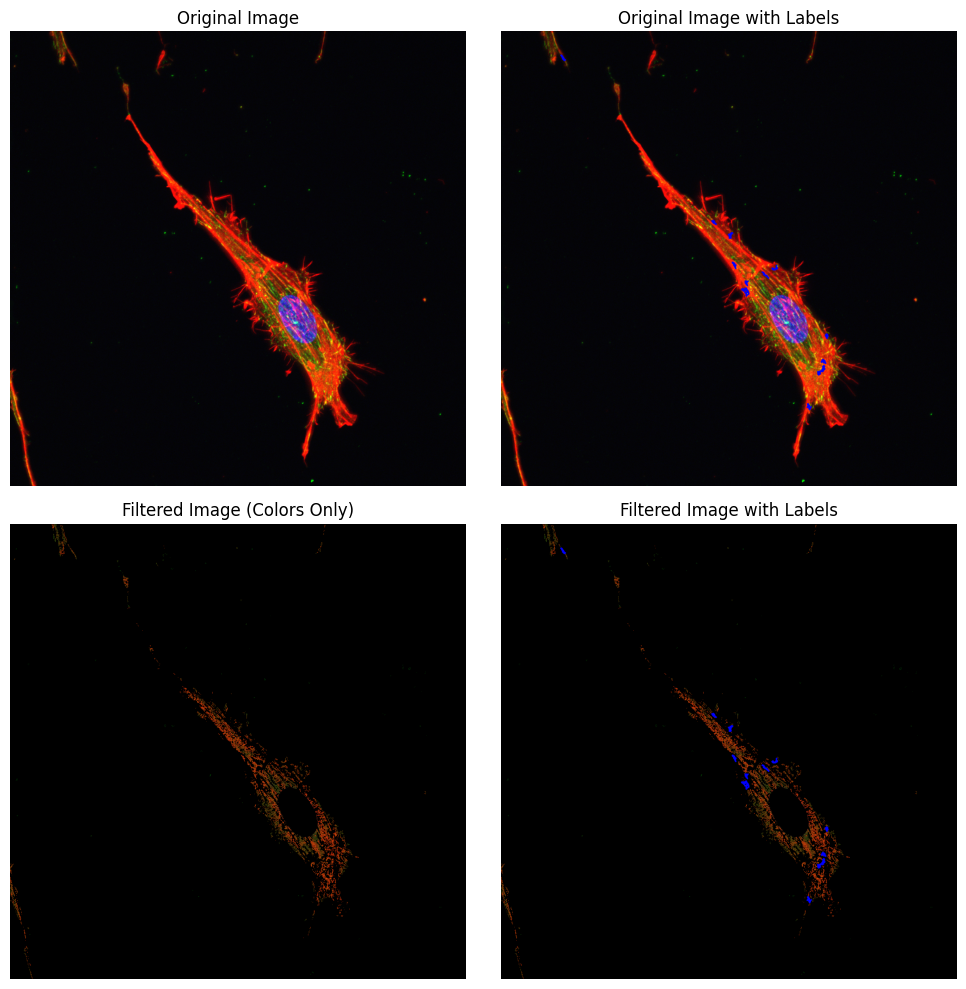

In [46]:
# 사용 예시
image = cv2.imread('./data/1/Soft/Soft_6_M.tif')
rgb_range = (r_min, r_max, g_min, g_max, b_min, b_max)
area_range = (area_min, area_max)
labeled_image, filtered_image, filtered_labeled_image, areas = process_and_visualize_labels(image, rgb_range, area_range)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Labels')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Filtered Image (Colors Only)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(filtered_labeled_image, cv2.COLOR_BGR2RGB))
plt.title('Filtered Image with Labels')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.imsave('../cell/figure/fig3/fig3_1.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imsave('../cell/figure/fig3/fig3_2.png', cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
plt.imsave('../cell/figure/fig3/fig3_3.png', cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
plt.imsave('../cell/figure/fig3/fig3_4.png', cv2.cvtColor(filtered_labeled_image, cv2.COLOR_BGR2RGB))

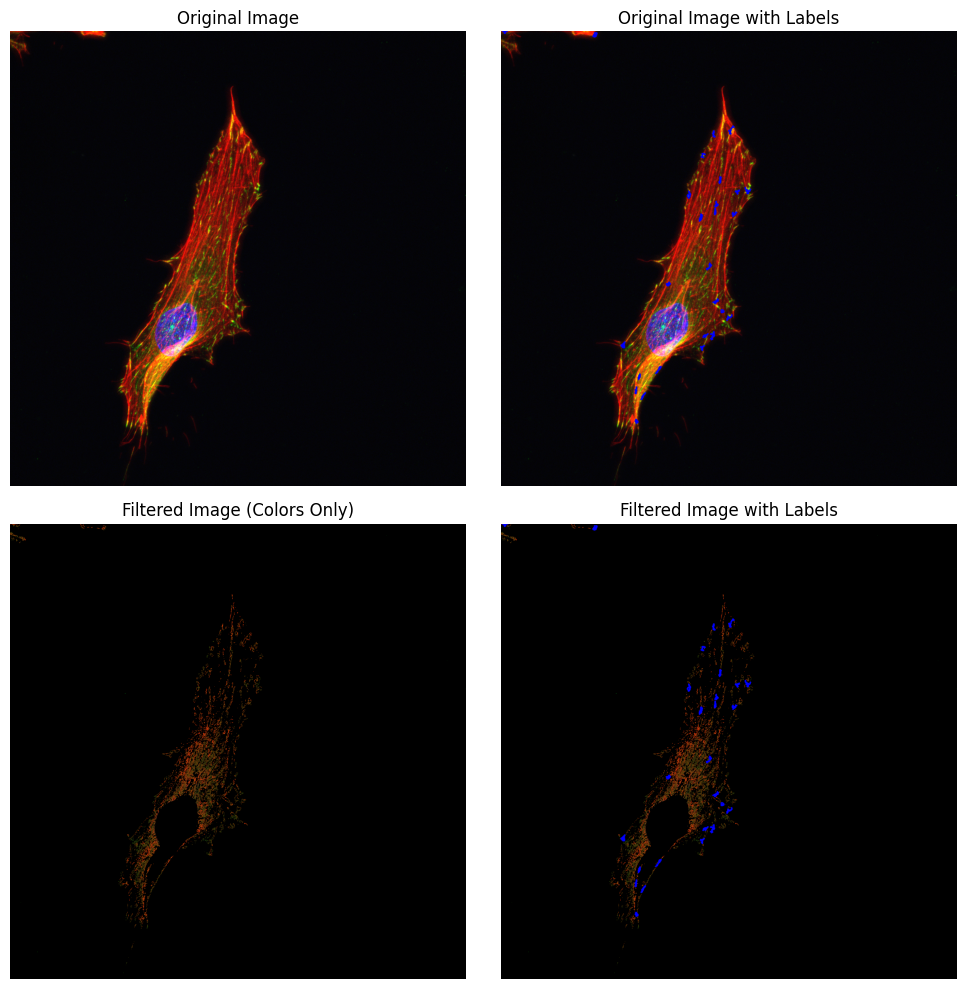

In [47]:
# 사용 예시
image = cv2.imread('./data/1/Stiff/Stiff_1_M.tif')
rgb_range = (r_min, r_max, g_min, g_max, b_min, b_max)
area_range = (area_min, area_max)
labeled_image, filtered_image, filtered_labeled_image, areas = process_and_visualize_labels(image, rgb_range, area_range)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Labels')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Filtered Image (Colors Only)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(filtered_labeled_image, cv2.COLOR_BGR2RGB))
plt.title('Filtered Image with Labels')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.imsave('../cell/figure/fig3/fig3_5.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imsave('../cell/figure/fig3/fig3_6.png', cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
plt.imsave('../cell/figure/fig3/fig3_7.png', cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
plt.imsave('../cell/figure/fig3/fig3_8.png', cv2.cvtColor(filtered_labeled_image, cv2.COLOR_BGR2RGB))